# Part 2

## Part 2 Network Analysis in Computational Social Science

These exercises are taken from Week 6: __Exercise 1: Mixing Patterns and Assortativity__ and __Exercise 3: Zachary's karate club__.

> __Exercise 1: Mixing Patterns and Assortativity__ 
>
> __Part 1: Assortativity Coefficient__ 
> 1. *Calculate the Assortativity Coefficient* for the network based on the country of each node. Implement the calculation using the formula provided during the lecture, also available in [this paper](https://arxiv.org/pdf/cond-mat/0209450.pdf) (equation 2, here for directed networks). **Do not use the NetworkX implementation.**
>


In [3]:
import json
import networkx as nx
import numpy as np

In [4]:
# Load the JSON file
with open("final_network.json", "r") as f:
    graph_data = json.load(f)

# Convert JSON back to NetworkX graph
G_loaded = nx.json_graph.node_link_graph(graph_data, directed=True)

In [9]:
# Ensure all nodes have a valid "country" attribute
for node in G_loaded.nodes:
    G_loaded.nodes[node]["country"] = G_loaded.nodes[node].get("country", "Unknown")

# Convert country names to numerical labels
list_of_countries = list(set(nx.get_node_attributes(G_loaded, "country").values()))
country_mapping = {country: i for i, country in enumerate(list_of_countries)}

# Apply the mapping directly to the graph
new_country_attributes = {}

for node in G_loaded.nodes:
    country_name = G_loaded.nodes[node]["country"]
    numeric_label = country_mapping[country_name]
    new_country_attributes[node] = {"country": numeric_label}

nx.set_node_attributes(G_loaded, new_country_attributes)

In [10]:
def assortativity_coefficient(G, attribute):
    """
    Compute the assortativity coefficient for a directed network based on a categorical node attribute.
    """
    edges = [(src, dst) for src, dst in G.edges if attribute in G.nodes[src] and attribute in G.nodes[dst]]

    # Extract numerical attribute values for each edge
    j_i = np.array([G.nodes[src][attribute] for src, dst in edges], dtype=np.float64)
    k_i = np.array([G.nodes[dst][attribute] for src, dst in edges], dtype=np.float64)

    M = len(j_i)  # Number of edges

    # Compute assortativity formula with improved numerical stability
    sum_jk = np.sum(j_i * k_i) / M
    sum_j = np.sum(j_i) / M
    sum_k = np.sum(k_i) / M
    sum_j2 = np.sum(j_i ** 2) / M
    sum_k2 = np.sum(k_i ** 2) / M

    numerator = sum_jk - sum_j * sum_k
    denominator = np.sqrt((sum_j2 - sum_j ** 2) * (sum_k2 - sum_k ** 2))

    return numerator / denominator if denominator != 0 else 0

# Compute assortativity coefficient
r = assortativity_coefficient(G_loaded, "country")
print("Manual Assortativity:", r)


Manual Assortativity: 0.3190435281711051


> __Part 2: Configuration model__
> In the following, we are going to assess the significance of the assortativity by comparing the network's assortativity coefficient against that of random networks generated through the configuration model.  
>
> 2. *Implement the configuration model* using the _double edge swap_ algorithm to generate random networks. Ensure each node retains its original degree but with altered connections. Create a function that does that by following these steps:
>   - **a.** Create an exact copy of your original network.
>   - **b.** Select two edges, $e_{1} = (u,v)$ and $e_{2} = (x,y)$, ensuring *u != y* and *v != x*.
>   - **c.** Flip the direction of $e_{1}$ to $e_{1} = (v,u)$ 50% of the time. This ensure that your final results is not biased, in case your edges were sorted (they usually are). 
>   - **d.** Ensure that new edges $e_{1}' = (e_{1}[0],e_{2}[1])$ and $e_{2}' = (e_{2}[0],e_{1}[1])$ do not already exist in the network.
>   - **e.** Remove edges $e_{1}$ and $e_{2}$ and add edges $e_{1}'$ and $e_{2}'$.
>   - **f.** Repeat steps **b** to **e** until you have performed _E*10_ swaps, where E is the total number of edges.


In [96]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [13]:
# Load the original network
with open("final_network.json", "r") as f:
    graph_data = json.load(f)

# Convert JSON back to a NetworkX graph
G_loaded = nx.node_link_graph(graph_data, directed=False)

In [72]:
def double_edge_swap(G, num_swaps_multiplier=10):

   # Create a deep copy of the graph
    G_copy = G.copy()

    edges = set(G_copy.edges())  # Ensure edges are undirected
    E = len(edges)  # Number of edges
    num_swaps = E * num_swaps_multiplier  # Total swaps to perform

    for _ in tqdm(range(num_swaps)):
        # Select two random edges (convert set to list first)
        edge_list = list(edges)  # Convert set to list for sampling
        e1, e2 = random.sample(edge_list, 2)
        u, v = e1
        x, y = e2

        # Randomly flip e1 direction to avoid sorting bias
        if random.random() < 0.5:
            u, v = v, u
        if random.random() < 0.5:
            x, y = y, x

        # Ensure valid swapping conditions
        if u != y and v != x and (u, y) not in G_copy.edges() and (x, v) not in G_copy.edges():
            if (x,y) in G_copy.edges() and (u,v) in G_copy.edges(): 
                # Remove old edges safely 
                G_copy.remove_edge(u, v)
                G_copy.remove_edge(x, y)

                # Add new edges
                G_copy.add_edge(u, y)
                G_copy.add_edge(x, v)

    return G_copy

In [73]:
G_randomized = double_edge_swap(G_loaded)

100%|██████████| 594320/594320 [18:02<00:00, 549.01it/s] 



> 3. *Double check that your algorithm works well*, by showing that the degree of nodes in the original network and the new 'randomized' version of the network are the same.
>
>


In [74]:
# Verify that the degree distributions are identical
original_degrees = dict(G_loaded.degree())
randomized_degrees = dict(G_randomized.degree())
print(len(original_degrees),len(randomized_degrees))


# Compare degree distributions
degree_match = all(original_degrees[node] == randomized_degrees[node] for node in G_loaded.nodes())

print("Degree distribution preserved:", degree_match)

15101 15101
Degree distribution preserved: True


> __Part 3: Analyzing Assortativity in Random Networks__  
>
> 4. *Generate and analyze at least 100 random networks* using the configuration model. For each, calculate the assortativity with respect to the country and plot the distribution of these values. Compare the results with the assortativity of your original network to determine if connections within the same country are significantly higher than chance.
>


In [82]:
import random
import itertools

def double_edge_swap_2(G, num_swaps_multiplier=10):

   # Create a deep copy of the graph
    G_copy = G.copy()
    G_copy = G_copy.to_undirected()

    E = len(G_copy.edges())
    nodes = list(itertools.chain(*list(G_copy.edges())))
    num_swaps = E * num_swaps_multiplier  # Total swaps to perform

    for _ in range(num_swaps): 
        x,u = random.sample(nodes,2)
        v = random.choice(list(G[u]))
        y = random.choice(list(G[x]))

        if u != y and x != v and (u, y) not in G_copy.edges() and (x, v) not in G_copy.edges():
            if (x,y) in G_copy.edges() and (u,v) in G_copy.edges(): 
            # Remove old edges safely 
                G_copy.remove_edge(u, v)
                G_copy.remove_edge(x, y)

                # Add new edges
                G_copy.add_edge(u, y)
                G_copy.add_edge(x, v)

    return G_copy

In [83]:
G_randomized = double_edge_swap_2(G_loaded)

In [84]:
# Verify that the degree distributions are identical
original_degrees = dict(G_loaded.degree())
randomized_degrees = dict(G_randomized.degree())
print(len(original_degrees),len(randomized_degrees))


# Compare degree distributions
degree_match = all(original_degrees[node] == randomized_degrees[node] for node in G_loaded.nodes())

print("Degree distribution preserved:", degree_match)

15101 15101
Degree distribution preserved: True


In [ ]:
def A_coefficient(G):
    # Select the attribute to compute assortativity
    attribute = "country"  # Change this to the attribute you want

    # Create a mapping from unique attribute values to numeric labels
    unique_values = set(data.get(attribute, "Unknown") for _, data in G.nodes(data=True))
    attribute_mapping = {val: i for i, val in enumerate(unique_values)}

    # Assign numeric labels to each node
    for node in G.nodes:
        if attribute in G.nodes[node]:
            G.nodes[node][attribute] = attribute_mapping[G.nodes[node][attribute]]
        else:
            G.nodes[node][attribute] = -1  # Default for missing values

    # Now try computing assortativity
    nx_r = nx.numeric_assortativity_coefficient(G, "country")

    return nx_r


In [104]:
from tqdm import tqdm

list_of_AC = []

for _ in tqdm(range(100)): 
    G_randomized = double_edge_swap_2(G_loaded)
    nx_value = A_coefficient(G_randomized)
    list_of_AC.append(nx_value)

100%|██████████| 100/100 [19:00<00:00, 11.41s/it]


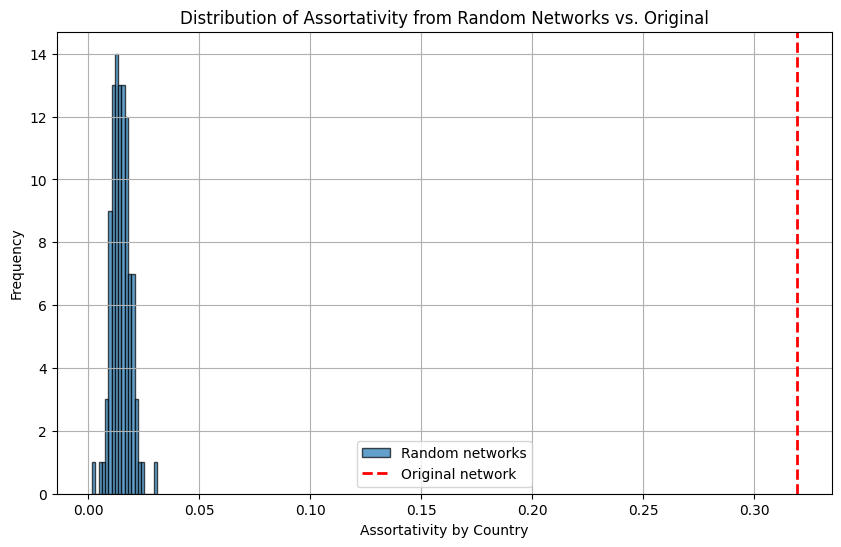

In [105]:
original_ac = r

plt.figure(figsize=(10, 6))
plt.hist(list_of_AC, bins=20, edgecolor='black', alpha=0.7, label='Random networks')
plt.axvline(original_ac, color='red', linestyle='--', linewidth=2, label='Original network')
plt.xlabel("Assortativity by Country")
plt.ylabel("Frequency")
plt.title("Distribution of Assortativity from Random Networks vs. Original")
plt.legend()
plt.grid(True)
plt.show()